# SVM PyTorch with MNIST [0 and 1]
- **Task**: Classification
- **Data**: MNIST Dataset
- **Model**: SVM
- **Loss function**: SVM Loss
- **Optimization**: Stochastic Gradient Descent

In [64]:
!pip install -q watermark

In [65]:
%load_ext watermark
%watermark -a 'Nguyen Van Sy Thinh' -v -p torch

Author: Nguyen Van Sy Thinh

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

torch: 2.3.0+cu121



## 1. Import Library

In [66]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt
import time

## 2. Data

### 2.1. MNIST Dataset

In [67]:
# Loading training data
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                               ]),
                               download=True)
# Loading test data
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                              ]))

### 2.2. Data Information

In [68]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 60000
Number of testing samples: 10000


In [69]:
print(f"Datatype of the 1st training sample: {train_dataset[0][0].type()}")
print(f"Size of the 1st training sample: {train_dataset[0][0].size()}")

Datatype of the 1st training sample: torch.FloatTensor
Size of the 1st training sample: torch.Size([1, 28, 28])


### 2.3. Data Visualization

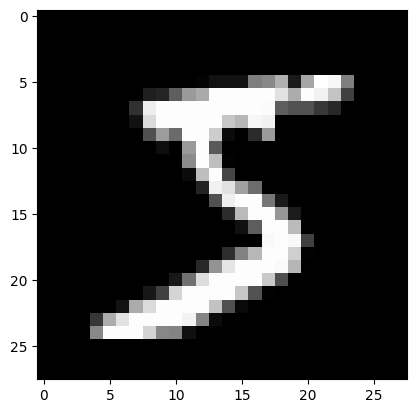

In [70]:
img_5 = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(img_5, cmap='gray')
plt.show()

### 2.4. Load Dataset into DataLoader

In [71]:
from torch.utils.data import DataLoader

# Load train and test data samples into dataloader
batch_size = 64
# Only select all samples with labels is 0 and 1
subset_indices = ((train_dataset.targets == 0) + (train_dataset.targets == 1)).nonzero().view(-1)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(subset_indices))
subset_indices = ((test_dataset.targets == 0) + (test_dataset.targets == 1)).nonzero().view(-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(subset_indices))

## 3. Model

In [72]:
import torch
import torch.nn as nn

class SVMModel(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.linear = nn.Linear(n_inputs, n_outputs)

    def forward(self, x):
        output = self.linear(x)
        return output

In [73]:
N_INPUTS = 28*28 # makes a 1D vector of 784
N_OUTPUTS = 1

In [74]:
model = SVMModel(n_inputs=N_INPUTS, n_outputs=N_OUTPUTS)

## 4. Loss Function and Optimization

In [75]:
LR = 0.001
EPOCHS = 50

In [76]:
class SVMLoss(nn.modules.Module):
    def __init__(self):
        super(SVMLoss,self).__init__()
    def forward(self, outputs, labels):
         return torch.sum(torch.clamp(1 - outputs.t()*labels, min=0))/batch_size

In [77]:
criterion = SVMLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

## 5. Train

In [78]:
losses = []
accs = []
for epoch in range(EPOCHS):
    start_time = time.time()
    avg_loss_epoch = 0
    batch_loss = 0
    total_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, 28*28)
        labels = Variable(2*(labels.float()-0.5))

        # Forward pass
        outputs = model(images)
        loss_svm = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss_svm.backward()
        optimizer.step()

        total_batches += 1
        batch_loss += loss_svm.item()

    avg_loss_epoch = batch_loss/total_batches
    losses.append(avg_loss_epoch)

    # Test the SVM Model
    correct = 0.
    total = 0.
    for i, (images, labels) in enumerate(test_loader):
        images = images.reshape(-1, 28*28)

        outputs = model(images)
        predicted = outputs.data >= 0
        total += labels.size(0)
        correct += (predicted.view(-1).long() == labels).sum()
    accuracy = 100 * correct / total
    accs.append(accuracy)
    print(f'[{epoch + 1}/{EPOCHS}] Epoch, Loss {avg_loss_epoch:.4f}, Accuracy {accuracy:.4f}, Time: {time.time() - start_time:.2f}s')

[1/50] Epoch, Loss 0.0418, Accuracy 99.8109, Time: 8.17s
[2/50] Epoch, Loss 0.0115, Accuracy 99.8582, Time: 14.07s
[3/50] Epoch, Loss 0.0090, Accuracy 99.8582, Time: 6.47s
[4/50] Epoch, Loss 0.0076, Accuracy 99.9054, Time: 3.90s
[5/50] Epoch, Loss 0.0067, Accuracy 99.9054, Time: 5.83s
[6/50] Epoch, Loss 0.0061, Accuracy 99.9054, Time: 6.74s
[7/50] Epoch, Loss 0.0057, Accuracy 99.9054, Time: 6.43s
[8/50] Epoch, Loss 0.0054, Accuracy 99.9054, Time: 3.88s
[9/50] Epoch, Loss 0.0051, Accuracy 99.9054, Time: 4.44s
[10/50] Epoch, Loss 0.0049, Accuracy 99.9054, Time: 4.73s
[11/50] Epoch, Loss 0.0047, Accuracy 99.9054, Time: 3.98s
[12/50] Epoch, Loss 0.0045, Accuracy 99.9054, Time: 4.13s
[13/50] Epoch, Loss 0.0044, Accuracy 99.9054, Time: 4.73s
[14/50] Epoch, Loss 0.0043, Accuracy 99.9054, Time: 3.96s
[15/50] Epoch, Loss 0.0042, Accuracy 99.9054, Time: 4.00s
[16/50] Epoch, Loss 0.0041, Accuracy 99.9054, Time: 4.89s
[17/50] Epoch, Loss 0.0040, Accuracy 99.9054, Time: 4.00s
[18/50] Epoch, Loss 0.

## 6. Inference

### 6.1. Loss Visualization

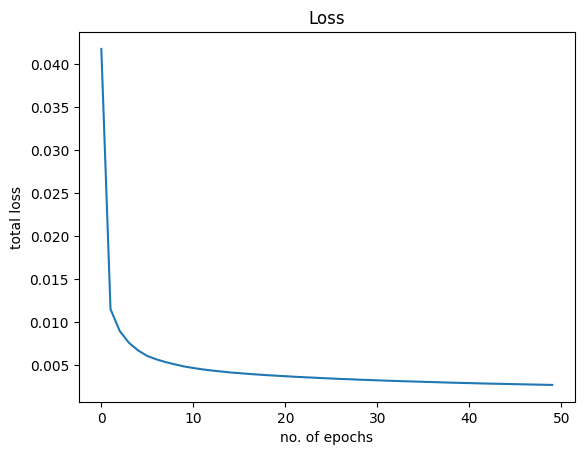

In [82]:
plt.plot(losses)
plt.xlabel("no. of epochs")
plt.ylabel("total loss")
plt.title("Loss")
plt.show()

### 6.2. Accuracy

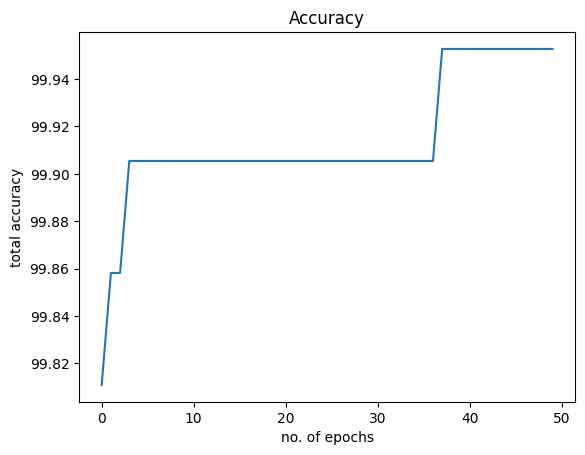

In [83]:
plt.plot(accs)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.title("Accuracy")
plt.show()

## 7. Conclusion
- **Accuracy**: 99.96% with two labels 0 and 1